In [1]:
import anndata as ad
import numpy as np
import scanpy as sc 

from core.preprocessor import Preprocessor
from core.normalizer import Normalizer
from core.differentiator import Differentiator
from core.model_tester import ModelTester
from plotmodules.norm_plots import *

CT_COUNTS_META_PATH = 'ct_counts_public_meta.h5ad'

ct_counts_metadata = ad.read_h5ad(CT_COUNTS_META_PATH)


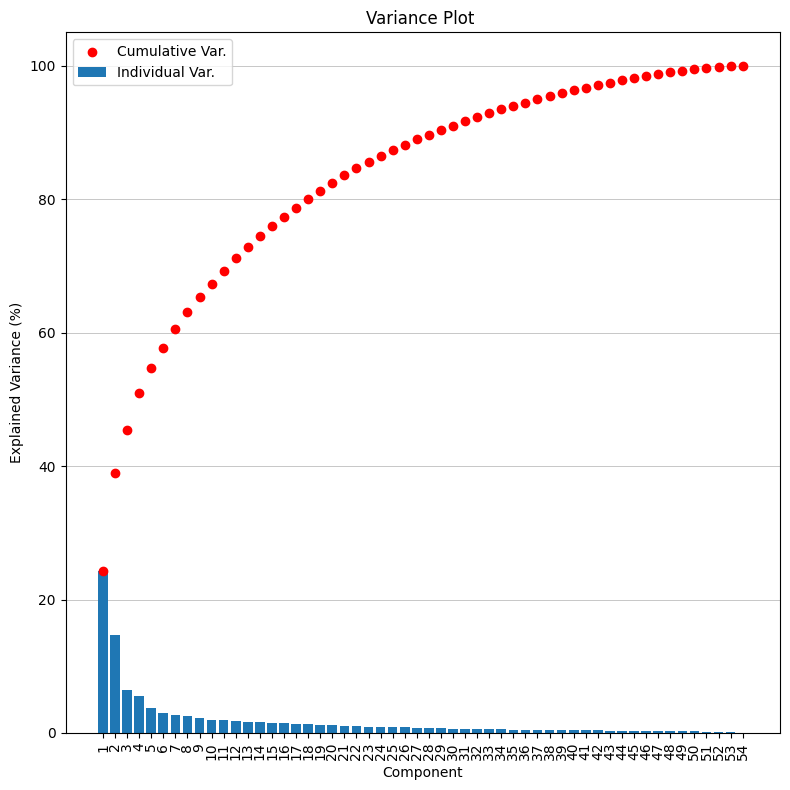

/home/jacob/Documents/BEP/bsc-thesis-scripts/core/preprocessor.py:55: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
/home/jacob/Documents/BEP/bsc-thesis-scripts/core/preprocessor.py:55: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


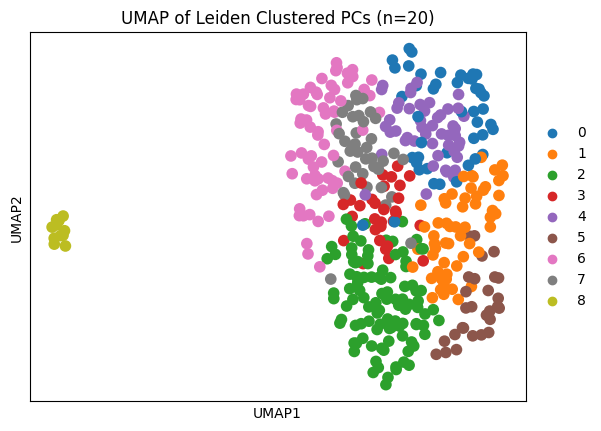

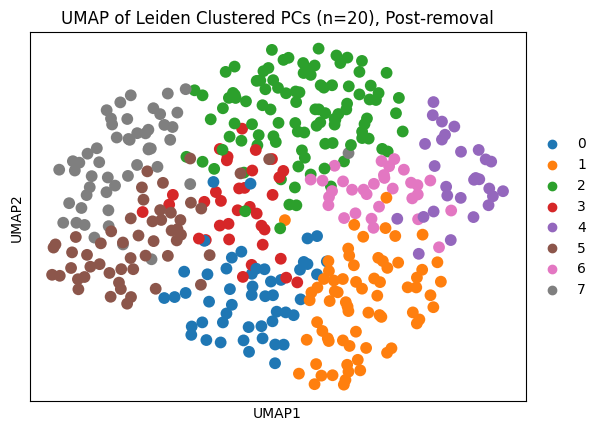

In [2]:
pp = Preprocessor('umap')
pp.show_pca(ct_counts_metadata)
pp.set_n_components(20)
pp.analyze_umap(ct_counts_metadata)
ct_counts_metadata = pp.remove_cluster(ct_counts_metadata, '8')

In [3]:
# Regress out post mortem interval
pp.regress_out(ct_counts_metadata, 'pmi')

/home/jacob/Documents/BEP/bsc-thesis-scripts/.venv/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:641: UserWarning: Received a view of an AnnData. Making a copy.


In [4]:
# Filter by braak stage and cogdx
ct_counts_metadata = ct_counts_metadata[(ct_counts_metadata.obs['cogdx'].isin([4, 5]) & ct_counts_metadata.obs['braaksc'].isin([4, 5, 6])) | 
                                        (ct_counts_metadata.obs['cogdx'].isin([1]) & ct_counts_metadata.obs['braaksc'].isin([0, 1, 2, 3]))]
pp.categorize(ct_counts_metadata, 'cogdx', pp.COGDX_MAP)
ct_counts_metadata.obs['cogdx_catcode'] = ct_counts_metadata.obs['cogdx_cat'].cat.codes
ct_counts_metadata.obs.value_counts(['cogdx_cat'])

/home/jacob/Documents/BEP/bsc-thesis-scripts/core/preprocessor.py:84: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


cogdx_cat
AD           108
H             99
Name: count, dtype: int64

In [5]:
# Normalize the data
normalizer = Normalizer(['l1', 'tmm', 'ref Oligodendrocytes', 'ref OPCs'], np.log1p)
normalizer.normalize_all(ct_counts_metadata)

for layer in normalizer.layer_names:
    #generate_clustermap(ct_counts_metadata, layer, 'cogdx_catcode')
    pass

In [6]:
# Differential abundance
from scipy.stats import ranksums
from statsmodels.stats.multitest import fdrcorrection

diff = Differentiator('l1', ranksums, fdrcorrection, 'cogdx_cat', ('AD', 'H'))
diff.differentiate(ct_counts_metadata)

log2( fold change ) = log2( AD/H )


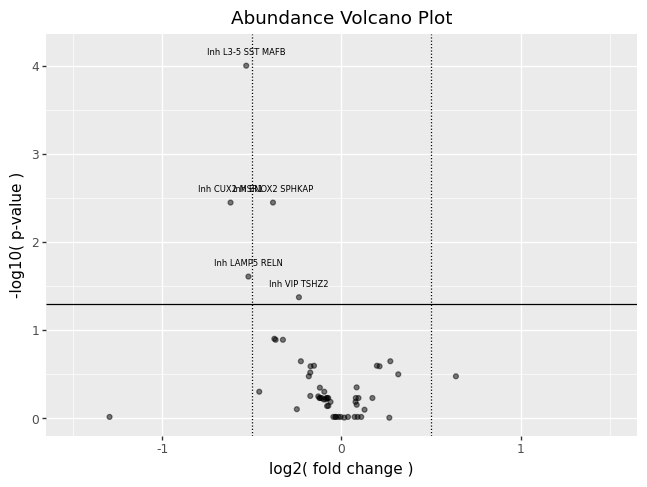

In [7]:
diff.volcano_plot(ct_counts_metadata)

In [8]:
diff.abundance_df.sort_values('corr_pvalue')

,significant,corr_pvalue,log2fc,log10p
Inh L3-5 SST MAFB,True,0.000100,-0.531404,3.999889
Inh CUX2 MSR1,True,0.003568,-0.618931,2.447585
Inh ENOX2 SPHKAP,True,0.003568,-0.382156,2.447585
Inh LAMP5 RELN,True,0.024638,-0.519180,1.608402
Inh VIP TSHZ2,True,0.042268,-0.237407,1.373988
Inh PTPRK FAM19A1,False,0.125062,-0.374485,0.902873
Inh L1 PAX6 CA4,False,0.128446,-0.326714,0.891280
Inh SORCS1 TTN,False,0.128446,-0.367316,0.891280
Mic P2RY12,False,0.224814,0.272507,0.648177
Inh L5-6 SST TH,False,0.224814,-0.226562,0.648177


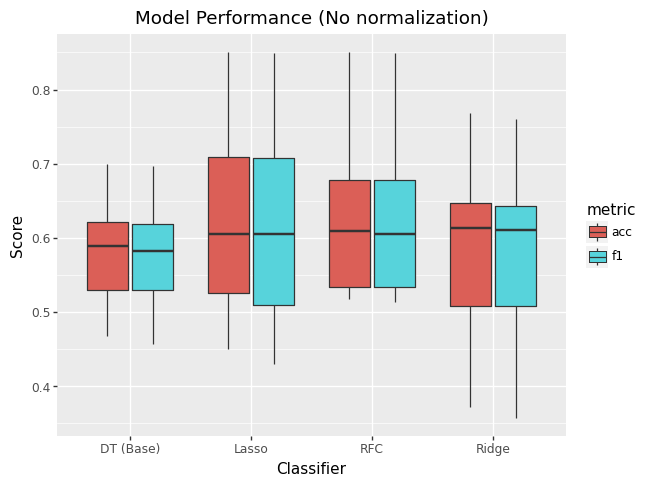

In [9]:
# Test models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Lasso, RidgeClassifier

tester = ModelTester(None, DecisionTreeClassifier(), 'cogdx_catcode', [0, 1], 10, random_state=42, verbose=False)
tester.test_baseline(ct_counts_metadata, 'DT (Base)')
tester.test_models(ct_counts_metadata, [RandomForestClassifier(), RidgeClassifier(), Lasso()], ['RFC', 'Ridge', 'Lasso'])
tester.plot_results('Model Performance (No normalization)')